In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from skimage.filters import gaussian
from vacation.data import GalaxyDataset
from tqdm import tqdm
import torchvision.transforms as T
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [20]:
train_ds_aug = GalaxyDataset(
    path="../../.data/Galaxy10_DECals_train.h5",
    device="cpu",
    max_cache_size="7G",
    cache_loaded=False,
)

In [21]:
valid_ds_aug = GalaxyDataset(
    path="../../.data/Galaxy10_DECals_valid.h5",
    device="cpu",
    max_cache_size="2G",
    cache_loaded=False,
)

In [22]:
train_ds = GalaxyDataset(
    path="../../.data/Galaxy10_DECals_proc_train.h5",
    device="cpu",
    max_cache_size="7G",
    cache_loaded=False,
)

In [23]:
print('length train_ds_aug',len(train_ds_aug))
print('length valid_ds_aug',len(valid_ds_aug))
print('length train_ds',len(train_ds))

length train_ds_aug 16813
length valid_ds_aug 4204
length train_ds 14188


In [ ]:
from torch.utils.data import Subset

n_train = 16000
n_val = 1000

np.random.seed(42)


train_indices = [
    int(i) for i in np.random.choice(len(train_ds), n_train, replace=False)
]
val_indices = [int(i) for i in np.random.choice(len(valid_ds_aug), n_val, replace=False)]
train_small = Subset(train_ds, train_indices)
val_small = Subset(valid_ds_aug, val_indices)

In [26]:
gaussian_filter = T.GaussianBlur(3, sigma=1.0)

In [27]:
def hog_features(df, length=None, pixels_per_cell=(12, 12), visualize=False):

    if length == None:
        n = len(df)
    else:
        n = length

    # example image to see the effect of HOG and the filter
    sample_image = df[0][0]
    sample_image = gaussian_filter(sample_image).permute(1, 2, 0).cpu().numpy()

    sample_fd, sample_image = hog(
        sample_image,
        orientations=9,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=(2, 2),
        visualize=True,
        channel_axis=-1,
    )

    # initialization of feature vector
    X = np.zeros((n, sample_fd.shape[0]), dtype=np.float32)
    y = np.zeros(n, dtype=np.int64)

    for i in tqdm(range(n)):
        image_tensor, label = df[i]
        image_np = gaussian_filter(image_tensor).permute(1, 2, 0).cpu().numpy()
        fd = hog(
            image_np,
            orientations=9,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=(2, 2),
            visualize=visualize,
            channel_axis=-1,
        )
        X[i] = fd
        y[i] = label
    return X, y, sample_image

In [28]:
X_train, y_train, example_image = hog_features(train_ds)

100%|██████████| 14188/14188 [06:46<00:00, 34.92it/s]


In [ ]:
len(valid_ds_aug)

In [29]:
X_val_aug, y_val_aug, _ = hog_features(valid_ds_aug)

100%|██████████| 4204/4204 [02:25<00:00, 28.91it/s]


In [30]:
np.save("rf_features_train_aug.npy",X_train)
np.save("rf_labels_train_aug.npy",y_train)
np.save("rf_features_valid_aug.npy", X_val_aug)
np.save("rf_labels_valid_aug.npy", y_val_aug)

In [31]:
X_train_aug = np.load("rf_features_train_aug.npy")
y_train_aug = np.load("rf_labels_train_aug.npy")

X_val_aug = np.load("rf_features_valid_aug.npy")
y_val_aug = np.load("rf_labels_valid_aug.npy")

In [14]:
print(len(X_train_aug), len(y_train_aug))
print(len(X_val_aug), len(y_val_aug))

28376 28376
11140 11140


In [32]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=30,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val_aug)
print(classification_report(y_val_aug, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.46      0.59       413
           1       0.72      0.80      0.75       425
           2       0.80      1.00      0.89       423
           3       0.84      0.81      0.82       423
           4       1.00      0.11      0.19       419
           5       0.88      0.81      0.85       419
           6       1.00      0.71      0.83       426
           7       0.47      0.99      0.63       420
           8       0.99      0.53      0.69       413
           9       0.54      0.91      0.67       423

    accuracy                           0.71      4204
   macro avg       0.80      0.71      0.69      4204
weighted avg       0.80      0.71      0.69      4204



In [33]:
y_train_pred = rf.predict(X_train_aug)

In [16]:
print(np.unique(y_val_aug, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1306, 1106,  846, 1042, 1569, 1022, 1119,  840, 1196, 1094]))


In [34]:
accuracy = accuracy_score(y_val_aug, y_pred)
cm = confusion_matrix(y_val_aug, y_pred)

In [35]:
print(accuracy, "on validation")
print(accuracy_score(y_train_aug, y_train_pred), "on train")

0.7136060894386299 on validation
0.9958415562447138 on train


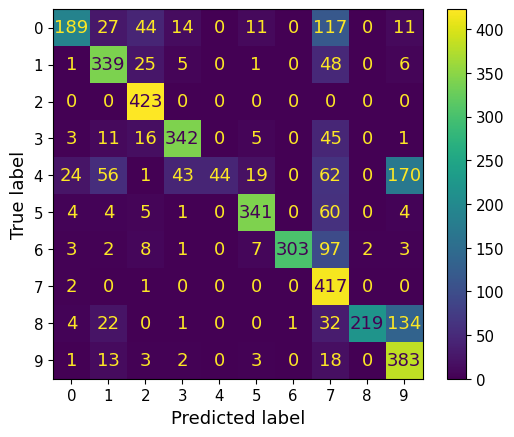

In [36]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [23]:
RF = RandomForestClassifier()

param_dist = {"n_estimators": randint(50,400),
              "max_features": ["sqrt","log2", None],
              "max_depth": randint(1,20),
              "min_samples_split": randint(2,10),
              "min_samples_leaf": randint(1,2),
              }

rand_search = RandomizedSearchCV(RF,
                                 param_distributions = param_dist,
                                 n_iter = 5, 
                                 cv = 5,
                                 n_jobs = -1,
                                 verbose = 1
                                )

rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [ ]:
best_rf = rand_search.best_estimator_
print("Best hyperparameters are:", rand_search.best_params_)

In [ ]:
y_pred = best_rf.predict(X_val)

cm = confusion_matrix(y_val, y_pred)

ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(
    "accuracy on validation set after hyperparameter optimization",
    accuracy_score(y_val, y_pred),
)

In [ ]:
misclassified_indices = np.where(y_pred != y_val)[0]
print(misclassified_indices)
misclassified = np.random.choice(misclassified_indices, 10)

class_names = [
    "Disturbed",
    "Merging",
    "Round Smooth",
    "In-between",
    "Cigar",
    "Barred Spiral",
    "Unbarred Spiral",
    "Unbarred Loose Spiral",
    "Edge-on without Bulge",
    "Edge-on with Bulge",
]

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
for i, ax in enumerate(axes.flat):
    idx = misclassified[i]
    image = valid_ds[int(idx)][0].permute(1, 2, 0).cpu().numpy()

    ax.imshow(image)
    ax.axis("off")
    ax.set_title(
        f"Pred: {class_names[y_pred[int(idx)]]}\n True: {class_names[y_val[int(idx)]]}"
    )

In [ ]:
plt.imshow(gaussian_filter(train_ds[0][0]).permute(1, 2, 0).cpu())

In [ ]:
plt.imshow(gaussian(train_ds[16500][0].permute(1, 2, 0).cpu()))

In [ ]:
image = train_ds[16500][0].permute(1, 2, 0).cpu()
image = gaussian(image, sigma=1.0)
fd, hog_image = hog(
    image,
    orientations=9,
    pixels_per_cell=(12, 12),
    cells_per_block=(1, 1),
    block_norm="L1",
    visualize=True,
    channel_axis=-1,
)

In [ ]:
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

In [ ]:
plt.imshow(hog_image_rescaled)